# Hyperbolic Embedding and Analysis of the Kapferer Multiplex Social Network

**Copyright (c) 2025, Martin Guillemaud. All rights reserved.**  
*Licensed under BSD 3-Clause License. See LICENSE file for details.*

This notebook demonstrates the application of hyperbolic embedding techniques to the Kapferer tailor shop dataset, a well-known example of a multiplex social network. By embedding the network layers into the Poincaré disk model, we can visualize and quantitatively analyze the structural differences and similarities between 2 time window separated by a strike. The workflow includes data loading, hyperbolic embedding, visualization, perturbation analysis, and the study of inter-layer coupling effects. This approach provides new insights into the geometry and dynamics of real-world multiplex networks.

Fore more information visit : http://casos.cs.cmu.edu/computational_tools/datasets/sets/kaptail/ 

### Import usefull librairies

In [1]:
# Core data manipulation and visualization libraries
from src.EmbeddingMethod import MlHypEmb  # Custom implementation for multilayer hyperbolic embedding
from src.Tools import hyp_disp_score     # Custom tool for computing hyperbolic displacement scores
import numpy as np                       # Numerical operations and array manipulation
import matplotlib.pyplot as plt          # Plotting library
import networkx as nx                    # Graph manipulation library
import pandas as pd                      # Data manipulation library

#%matplotlib qt  # Uncomment to display plots in separate window

### Import Data 

In [2]:
# Graph type selection: Social or Instrumental networks
graph_type = 'Social'

# Define file paths for both graph types
filenames_social = ['Data/kaptail/kaptail_agent_agent[KAPFTS1].csv', 
                    'Data/kaptail/kaptail_agent_agent[KAPFTS2].csv']
filenames_instrumental = ['Data/kaptail/kaptail_agent_agent[KAPFTI1].csv', 
                    'Data/kaptail/kaptail_agent_agent[KAPFTI2].csv']

# Select appropriate filenames based on graph type
if graph_type == 'Instrumental':
    filenames = filenames_instrumental
elif graph_type == 'Social':
    filenames = filenames_social
else:
    raise ValueError('graph_type must be either "Social" or "Instrumental"')

# Initialize containers for graph data
G_tot = []          # List to store NetworkX graph objects
matrices_tot = []    # List to store adjacency matrices

# Process each network layer
for filename in filenames:
    # Load CSV data (assumes no header)
    df = pd.read_csv(filename, header=None)
    
    # Convert dataframe to adjacency matrix
    adj_matrix = df.iloc[:, :-1].to_numpy()
    
    # Create NetworkX graph from adjacency matrix
    G = nx.from_numpy_array(adj_matrix)
    
    # Store both graph and matrix representations
    G_tot.append(G)
    matrices_tot.append(nx.to_numpy_array(G))

# Define layer names for visualization
layers_names = np.arange(len(G_tot))

# Store total number of layers
n_layers = len(layers_names)

### Embedding in Poincaré Disk 

In [3]:
# Embeddings hyperparameters
preweight = True  # Whether to use pre-weighting for the embedding
weight = 'weight'  # Edge weight attribute name
beta = 1200 
eta = 'auto'  
beta_dist = 10  # Distance scaling parameter
metric = 'precomputed'  # Distance metric for the embedding

# Initialize the multilayer hyperbolic embedding object with parameters
Emb_obj = MlHypEmb(preweight=preweight, 
                   weight=weight, 
                   beta=beta, 
                   eta=eta, 
                   method='Isomap',  # Using Isomap for dimensionality reduction
                   beta_dist=beta_dist, 
                   metric=metric, 
                   n_neighbors='auto',  # Automatic neighbor selection
                   radius='degree')  # Use node degree for radius calculation

# Load the network data into the embedding object
# mu_mat=30 controls the coupling strength between layers
Emb_obj.Load_data(matrices=matrices_tot, mu_mat=30)

# Perform the embedding computation
# n_jobs=-1 uses all available CPU cores
Emb_obj.Embedding(n_jobs=-1)

[I] Object of class MlHypEmb well initiated


### Visualization 

Plotting layer: 0 0
Plotting layer: 1 1


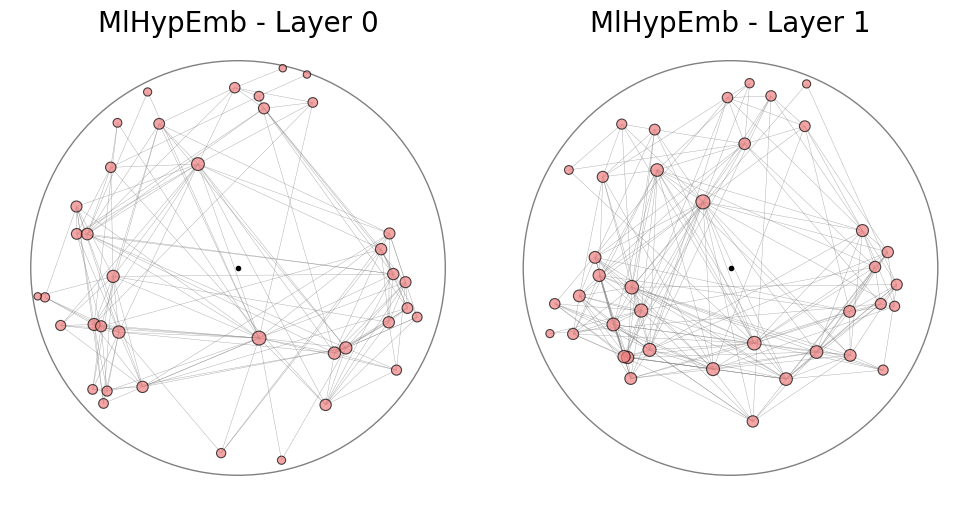

In [4]:
# Set up figure size and styling for the plot (one subplot per layer)
fig = plt.figure(figsize=(n_layers*5, 5 ))
plt.rcParams['axes.linewidth'] = 2  # Set line width for axes borders

# Iterate over each layer in the multiplex network
for layer_i in range(len(layers_names)):
    # Get Layer information
    layer_id = list(layers_names)[layer_i]  
    layer_name = layers_names[layer_id]  # Current layer name/index
    
    print('Plotting layer:', layer_name, layer_id)  
    
    # Create subplot for current layer
    ax1 = fig.add_subplot(1, n_layers, layer_i + 1)
    
    # Get network and embedding data for current layer
    G = G_tot[layer_i]  # Graph structure
    pos_G = Emb_obj.embeddings[layer_i]  # 2D hyperbolic embedding coordinates
    
    # Create dictionary mapping node IDs to their positions
    pos_G_d = {node: pos_G[i, :] for i, node in enumerate(G.nodes())}

    # Plot origin point and boundary circle
    ax1.plot([0], [0], 'o', color='black', markersize=3)  # Origin point
    circle = plt.Circle((0, 0), 1, edgecolor='gray', facecolor='none', linewidth=1)  # Unit circle (Poincaré disk boundary)
    ax1.add_artist(circle)

    # Calculate node sizes based on weighted degree
    deg = np.array(list(dict(G.degree(weight='weight')).values()))
    node_size = np.sqrt(deg + 1) * 20  # Scale node sizes for better visualization

    # Draw the network
    nx.draw_networkx_nodes(
        G, pos_G_d, node_size=node_size, ax=ax1, node_color='lightcoral',
        node_shape='o', edgecolors='k', linewidths=0.8, alpha=0.7
    )
    nx.draw_networkx_edges(
        G, pos_G_d, width=0.3, ax=ax1, edge_color='grey', alpha=0.7
    )

    # Configure plot appearance
    ax1.set_xlim(-1.1, 1.1)  # Set x-axis range for Poincaré disk
    ax1.set_ylim(-1.1, 1.1)  # Set y-axis range for Poincaré disk
    ax1.axis("off")  # Hide axes for cleaner visualization
    ax1.set_title(f'MlHypEmb - Layer {layer_name}', fontsize=20)
    ax1.set_aspect('equal', 'box')  # Maintain circular shape of Poincaré disk

# Adjust subplot spacing
fig.tight_layout()

# Display the visualization
plt.show()


### Perturbation score calculation 

In [5]:
# Calculate the hyperbolic displacement score between layers 0 and 1
# This measures how much nodes' positions change between the two layers
error = hyp_disp_score(Emb_obj.embeddings[0], Emb_obj.embeddings[1])

# Set a maximum threshold for the scores to handle outliers
# Any score above th_score will be capped at th_score value
th_score = 100
error = np.array(error)
error[error>th_score]=th_score

### Plot perturbation score 

Plotting layer: 0 0
Plotting layer: 1 1


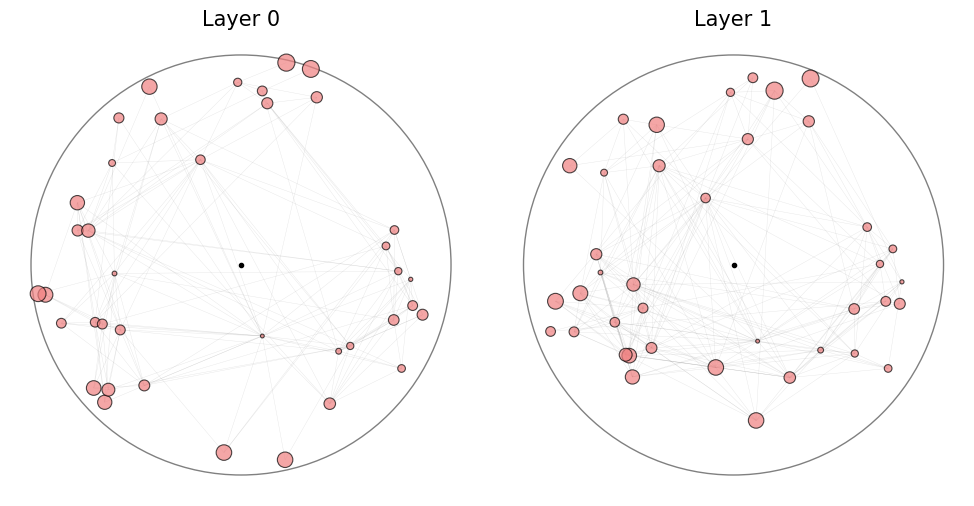

In [6]:
# Set up figure size and styling for the visualization of perturbation scores
fig = plt.figure(figsize=(n_layers*5, 5))  # Size scales with number of layers
plt.rcParams['axes.linewidth'] = 2  # Enhance axis visibility

# Iterate through each layer in the multiplex network
for layer_i in range(len(layers_names)):
    # Extract layer identification information
    layer_id = list(layers_names)[layer_i]  
    layer_name = layers_names[int(layer_id)]  
    
    print('Plotting layer:', layer_name, layer_id)  
    
    # Create subplot for current layer
    ax1 = fig.add_subplot(1, n_layers, layer_i + 1)
    
    # Get network structure and embedding coordinates for current layer
    G = G_tot[layer_i]  # Network graph
    pos_G = Emb_obj.embeddings[layer_i]  # Node positions in hyperbolic space
    
    # Create mapping from node IDs to their embedded coordinates
    pos_G_d = {node: pos_G[i, :] for i, node in enumerate(G.nodes())}

    # Plot the Poincaré disk boundary and center
    ax1.plot([0], [0], 'o', color='black', markersize=3)  # Center point
    circle = plt.Circle((0, 0), 1, edgecolor='gray', facecolor='none', linewidth=1)  # Boundary circle
    ax1.add_artist(circle)

    # Draw network elements with perturbation scores determining node sizes
    nx.draw_networkx_nodes(
        G, pos_G_d, 
        node_size=np.log(np.array(error)+1)*120,  # Node size reflects perturbation score
        ax=ax1, 
        node_color='lightcoral',
        node_shape='o', 
        edgecolors='k', 
        linewidths=0.8, 
        alpha=0.7
    )
    nx.draw_networkx_edges(
        G, pos_G_d, 
        width=0.3, 
        ax=ax1, 
        edge_color='grey', 
        alpha=0.2  # Reduced edge visibility to emphasize nodes
    )

    # Configure plot aesthetics
    ax1.set_xlim(-1.1, 1.1)  # Set Poincaré disk boundaries
    ax1.set_ylim(-1.1, 1.1)
    ax1.axis("off")  # Remove axes for cleaner visualization
    ax1.set_title(f'Layer {layer_name}', fontsize=15)
    ax1.set_aspect('equal', 'box')  # Maintain circular shape

# Adjust layout and display
fig.tight_layout()
plt.show()


### Evolution of coupling with $\mu$

In [7]:
# Select specific layers to compare from the multilayer network
A_1 = matrices_tot[0]  # Adjacency matrix of first layer
A_2 = matrices_tot[1]  # Adjacency matrix of second layer

# Define range of coupling parameter mu for analysis
# More points (300) for finer granularity in the evolution
mu_list = np.linspace(0.1, 35, 300)

# Create NetworkX graph objects for both layers
G_mu_tot = [nx.from_numpy_array(A_1), nx.from_numpy_array(A_2)]

# Initialize storage for results
global_score_tot = []    # Store global displacement scores
embeddings_tot = []      # Store embeddings for each mu value
local_score_tot = []     # Store node-wise displacement scores

# Iterate through different coupling strengths
for mu in mu_list:
    # Prepare adjacency matrices for current iteration
    mat_tot = [A_1, A_2]
    
    # Initialize embedding object with parameters defined earlier
    Emb_obj = MlHypEmb(
        preweight=preweight, 
        weight=weight,
        beta=beta, 
        eta=eta,
        method='Isomap',
        beta_dist=beta_dist,
        metric=metric,
        n_neighbors='auto',
        radius='degree',
        message=False
    )
    
    # Load network data with current coupling strength
    Emb_obj.Load_data(matrices=mat_tot, mu_mat=float(mu))
    
    # Compute hyperbolic embeddings
    Emb_obj.Embedding(n_jobs=-1)
    
    # Calculate displacement scores between layers
    scores_val = np.array(hyp_disp_score(Emb_obj.embeddings[0], Emb_obj.embeddings[1]))
    scores_val[np.isinf(scores_val)] = 2  # Handle infinite values
    score = np.median(scores_val)  # Use median for global score
    
    # Store results for this mu value
    global_score_tot.append(score)
    local_score_tot.append(scores_val)
    embeddings_tot.append([Emb_obj.embeddings[0], Emb_obj.embeddings[1]])

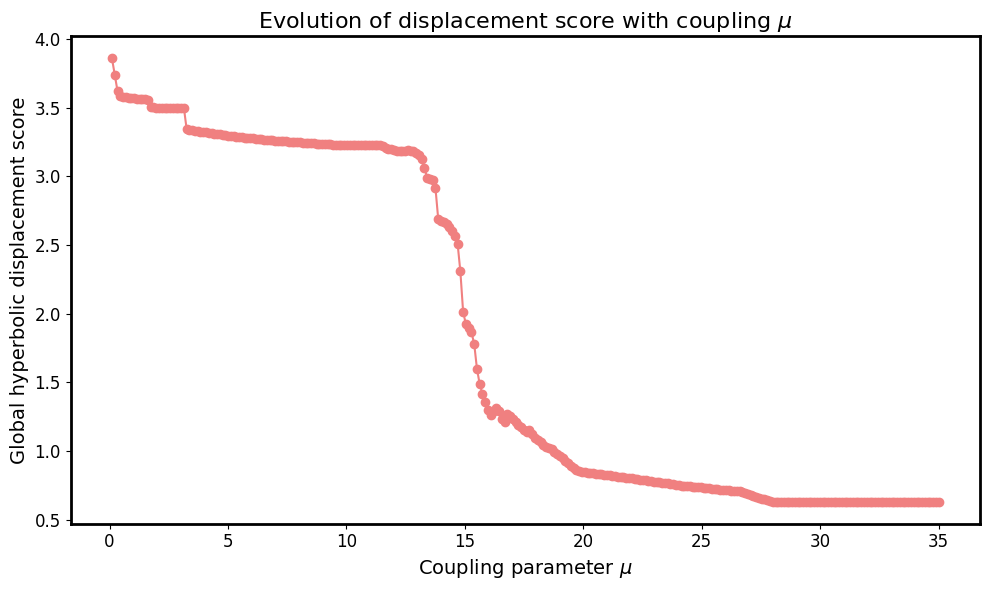

In [8]:
## Plot evolution of hyperbolic displacement score vs coupling parameter

# Plot global displacement score as a function of coupling parameter mu
fig, ax = plt.subplots(figsize=(10, 6))

# Plot data with markers and line
ax.plot(
    mu_list,  # Coupling parameter values
    global_score_tot,  # Global displacement scores
    marker='o',  
    linestyle='-',  
    color='lightcoral',  
    markersize=6,
    label='Global displacement score'  # More descriptive label
)

# Add descriptive labels and title
ax.set_xlabel(r'Coupling parameter $\mu$', fontsize=14)  # More descriptive x-label
ax.set_ylabel('Global hyperbolic displacement score', fontsize=14)  # More specific y-label
ax.set_title(r'Evolution of displacement score with coupling $\mu$', fontsize=16)

# Configure tick label sizes
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Adjust layout and display
fig.tight_layout()
#plt.savefig('kaptail_score_vs_mu_1.pdf')
plt.show()


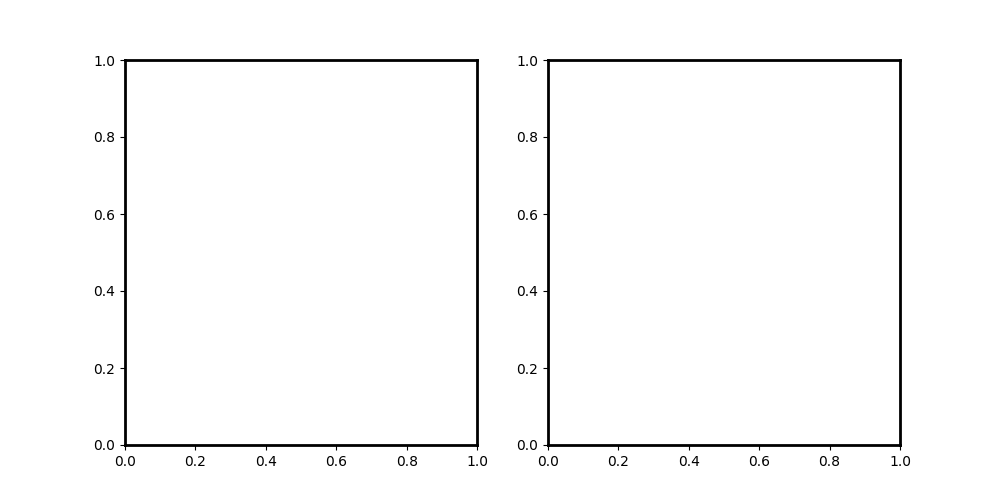

In [9]:
from matplotlib.animation import FuncAnimation
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# %matplotlib inline is preferred for Jupyter notebook for inline plotting.
# %matplotlib qt is for an interactive window. You can use either depending on your preference.

# To open an external window
#%matplotlib notebook
#%matplotlib qt
%matplotlib widget

# Necessary variables 
#mu_list, embeddings_tot, G_tot, and layers_names
layers_names = ['Control', 'Other']

# Define function to update the plot for each frame (for each mu)
def update(i_mu):
    # Get data of the current mu
    mu = mu_list[i_mu]
    embeddings = embeddings_tot[i_mu]

    # Clear the previous plot to update with new data
    for ax in axs:
        ax.clear()

    # Plot data for each layer
    for layer_i in range(len(layers_names)):
        ax = axs[layer_i]  # Get the axis for the current layer
        layer_name = layers_names[layer_i]

        # Get the corresponding graph and embedding for this layer
        G = G_mu_tot[layer_i]  # Graph of the current layer
        pos_G = embeddings[layer_i]  # Embedding positions for this layer
        pos_G_d = {node: pos_G[i, :] for i, node in enumerate(G.nodes())}

        # Calculate node sizes based on degree
        #deg = np.array(list(dict(G.degree(weight='weight')).values()))
        #node_size = np.sqrt(deg + 1) * 20  # Adjust node size
        scores = local_score_tot[i_mu]
        node_size = np.log(np.array(scores)+1)*50

        # Plot the nodes and edges
        nx.draw_networkx_nodes(
            G, pos_G_d, node_size=node_size, ax=ax, node_color='lightcoral',
            node_shape='o', edgecolors='k', linewidths=0.8, alpha=0.7
        )
        nx.draw_networkx_edges(
            G, pos_G_d, width=0.3, ax=ax, edge_color='grey', alpha=0.7
        )

        # Add a circle around the central point (optional visual boundary)
        ax.plot([0], [0], 'o', color='black', markersize=3)  # Central point
        circle = plt.Circle((0, 0), 1, edgecolor='gray', facecolor='none', linewidth=1)
        ax.add_artist(circle)

        # Styling for each subplot
        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.1, 1.1)
        ax.axis("off")  # Hide axis
        ax.set_title(f'MlHypEmb - Layer {layer_name}, mu = {mu:.2f}', fontsize=12)
        ax.set_aspect('equal', 'box')  # Equal aspect ratio

    # Adjust layout to avoid overlap
    fig.tight_layout()

# Create the figure
n_layers = len(layers_names)
fig, axs = plt.subplots(1, n_layers, figsize=(n_layers*5, 5))

# Create an animation that updates the plot for each value of mu
ani = FuncAnimation(
    fig, update, frames=range(len(mu_list)), interval=20, repeat=True
)

# To save as .gif:
#ani.save('graph_embedding_evolution_kaptail_1.gif', writer='pillow', fps=10)

# Display the animation
plt.show()